# <span style="color:BLUE">  Step 3: Predictive model

In this notebook, we begin by loading the cleaned LendingClub dataset (`EDA_cleaned_lending_dataset.csv`) and proceed with a series of statistical analyses aimed at preparing the data for predictive modeling. The steps include:

1. Applying one-hot encoding to transform categorical variables into numerical format
3. Preparing training and test datasets
4. Model building 
5. Model Evaluation based on evaluation metrics
6. Save the model 

**Output from this notebook**: A comprehensive data analysis summary that supports model development, informs business strategy, and highlights the most predictive features for loan approval.

Based on our Exploratory Data Analysis (EDA), we identify **`loan_status`** as a key variable for indicating the decision of loan approval. It effectively captures critical aspects such as **loan performance** and **credit risk**, making it a strong candidate for the **target variable** in our predictive model.

All other variables will serve as **input features** to help predict `loan_status`. In the context of data science, `loan_status` is the **dependent variable**, while the remaining features act as **independent variables**.

Furthermore, we drop other categorical variables, as they do not significantly influence loan approval decisions. Instead, these variables offer general insights into borrower characteristics but do not directly contribute to the prediction outcome.

**1. Loading the dataset**

In [168]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_name = "EDA_cleaned_lending_dataset.csv"
df = pd.read_csv(file_name)
df.head(5)

,pub_rec_bankruptcies,loan_status,total_acc,term_numeric,loan_income_ratio,high_util_flag,fico_score_capped,annual_inc_capped,dti_capped,loan_term_ratio_capped,int_rate_numeric_capped,loan_amnt_capped
0,0.0,Current,24.0,60.0,0.421053,False,682.0,57000.0,25.33,46.002997,9.0,24000.0
1,0.0,Fully Paid,9.0,36.0,0.090909,False,667.0,55000.0,7.22,30.771124,10.0,5000.0
2,0.0,Current,23.0,60.0,0.551724,False,752.0,43500.0,24.55,45.940048,11.0,24000.0
3,0.0,Fully Paid,23.0,60.0,0.291667,False,737.0,48000.0,24.30,43.371852,13.0,14000.0
4,1.0,Defaulters,7.0,36.0,0.086957,False,702.0,46000.0,11.56,30.328304,11.0,4000.0


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96999 entries, 0 to 96998
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pub_rec_bankruptcies     96999 non-null  float64
 1   loan_status              96999 non-null  object 
 2   total_acc                96999 non-null  float64
 3   term_numeric             96999 non-null  float64
 4   loan_income_ratio        96999 non-null  float64
 5   high_util_flag           96999 non-null  bool   
 6   fico_score_capped        96999 non-null  float64
 7   annual_inc_capped        96999 non-null  float64
 8   dti_capped               96999 non-null  float64
 9   loan_term_ratio_capped   96999 non-null  float64
 10  int_rate_numeric_capped  96999 non-null  float64
 11  loan_amnt_capped         96999 non-null  float64
dtypes: bool(1), float64(10), object(1)
memory usage: 8.2+ MB


`high_util_flag` is boolean variable which has to be converted to the numeric variable

In [171]:
df['high_util_flag'] = df['high_util_flag'].astype(float) #Convert to numeric value

In [172]:
def check_infinity(df):
    infinite_list = df.isin([-np.inf, np.inf]).sum()

    if infinite_list.sum() == 0:
        print("No column has infinite values")
    else:
        print("Columns with infinite values:")
        print(infinite_list[infinite_list>0])

check_infinity(df)

Columns with infinite values:
loan_income_ratio    1
dtype: int64


In [173]:
df.loc[:, "loan_income_ratio"] = df["loan_income_ratio"].replace(np.inf, 999)
check_infinity(df)

No column has infinite values


**Update the `loan_status` to the boolean variables**

In [175]:
#df_clean['loan_default']= df_clean['loan_status'] == 'Charged Off'
df.loc[:, 'loan_default'] = df['loan_status'] == 'Defaulters' 

**2. Prepare the training and test datasets**

In [177]:
features = ['pub_rec_bankruptcies', 'total_acc', 'term_numeric', 'loan_income_ratio',  'high_util_flag',
            'fico_score_capped', 'annual_inc_capped','dti_capped', 
            'loan_term_ratio_capped', 'int_rate_numeric_capped','loan_amnt_capped' ]

In [178]:
X = df[features]
y = df['loan_default']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42)
for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (77599, 11)
Shape: (19400, 11)
Shape: (77599,)
Shape: (19400,)


**3. Building the baseline model**

Based on our Exploratory Data Analysis (EDA), the `loan_status` variable emerges as a pivotal indicator of loan approval outcomes. It encapsulates essential information regarding loan performance and credit risk, rendering it an ideal choice for the **target variable** in our predictive modeling efforts.

The remaining variables in the dataset will serve as **input features** or **independent variables**, providing the necessary context to predict the `loan_status`.

Given that `loan_status` comprises two distinct categories—"Default" and "Not-Default"—the problem is inherently a **binary classification task**. This classification framework enables the application of various machine learning algorithms, such as Random Forests, or Gradient Boosting Machines, to develop a model capable of accurately forecasting loan approval decisions.

By framing the problem in this manner, we can leverage supervised learning techniques to train a model that predicts the likelihood of a loan default, thereby aiding in risk assessment and decision-making processes.


**Model 1 - Random Forest Classifier**

In [257]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [182]:
from dsif6utility import model_evaluation_report

# Compute predicted probabilities (for the positive class)
y_pred = model_RF.predict(X_test)
y_pred_prob = model_RF.predict_proba(X_test)[:, 1]

model_evaluation_report(X_test, y_test, y_pred, y_pred_prob)

Accuracy: 0.8646907216494846
Precision: 0.36036036036036034
Recall: 0.015420200462606014
F1-Score: 0.029574861367837338
ROC-AUC: 0.6563990345262564
Confusion Matrix:
[[16735    71]
 [ 2554    40]]


**Model evaluation**

**Confusion Matrix**

The confusion matrix helps us understand the performance of a classification model by showing the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.

**Evaluation Metrics**

-   **Accuracy**: Proportion of correct predictions (TP + TN) / Total predictions.
-   **Precision**: Proportion of positive predictions that were correct TP / (TP + FP).
-   **Recall**: Proportion of actual positives that were correctly identified TP / (TP + FN).
-   **F1-Score**: Harmonic mean of precision and recall.
-   **ROC-AUC**: Area under the Receiver Operating Characteristic curve, a measure of how well the model can distinguish between classes.


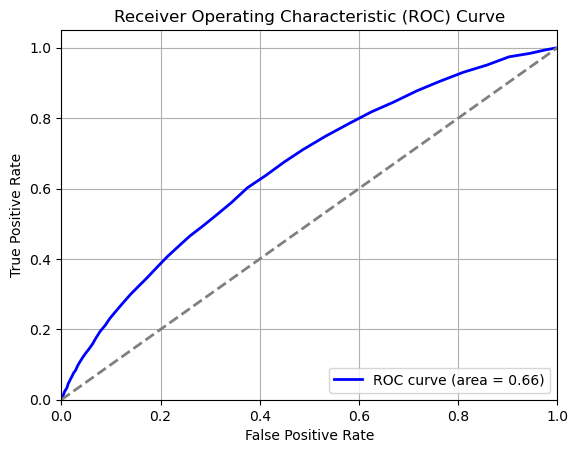

ROC AUC Score: 0.66


In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute predicted probabilities (for the positive class)
y_pred_prob = model_RF.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}')

A 0.66 ROC AUC score indicates that my model has a 66% probability of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance for "Defaulters" category borrower. 

**Model 2 - XGB Classifier**

In [311]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42)

for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (77599, 11)
Shape: (19400, 11)
Shape: (77599,)
Shape: (19400,)


In [313]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier(n_estimators=100, random_state=42)
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

**Model evaluation**

In [190]:
from dsif6utility import model_evaluation_report
# Compute predicted probabilities (for the positive class)
y_pred = model_XGB.predict(X_test)
y_pred_prob = model_XGB.predict_proba(X_test)[:, 1]
model_evaluation_report(X_test, y_test, y_pred, y_pred_prob)

Accuracy: 0.8642783505154639
Precision: 0.29896907216494845
Recall: 0.01117964533538936
F1-Score: 0.021553325901151988
ROC-AUC: 0.6706450343440328
Confusion Matrix:
[[16738    68]
 [ 2565    29]]


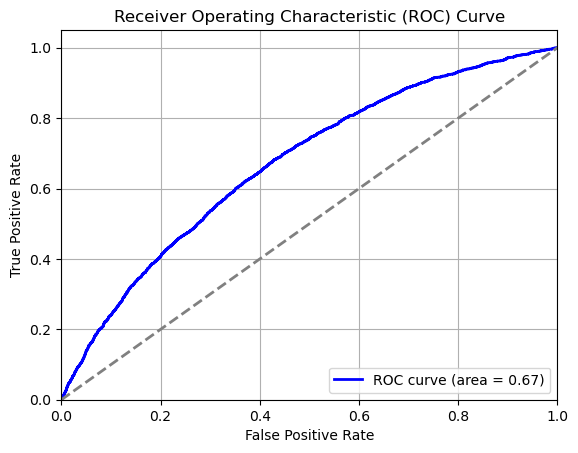

ROC AUC Score: 0.67


In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute predicted probabilities (for the positive class)
y_pred_prob = model_XGB.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}')

A 0.66 ROC AUC score indicates that my model has a 67% probability of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance for "Defaulters" category borrower.

**4. Comparing the model_RF and model_XGB performance:**

In [194]:
#Random Forest Classifier
# Compute predicted probabilities (for the positive class)
y_pred = model_RF.predict(X_test)
y_pred_prob = model_RF.predict_proba(X_test)[:, 1]
model_evaluation_report(X_test, y_test, y_pred, y_pred_prob)

Accuracy: 0.8646907216494846
Precision: 0.36036036036036034
Recall: 0.015420200462606014
F1-Score: 0.029574861367837338
ROC-AUC: 0.6563990345262564
Confusion Matrix:
[[16735    71]
 [ 2554    40]]


In [195]:
#XGBoost Classifier
# Compute predicted probabilities (for the positive class)
y_pred = model_XGB.predict(X_test)
y_pred_prob = model_XGB.predict_proba(X_test)[:, 1]
model_evaluation_report(X_test, y_test, y_pred, y_pred_prob)

Accuracy: 0.8642783505154639
Precision: 0.29896907216494845
Recall: 0.01117964533538936
F1-Score: 0.021553325901151988
ROC-AUC: 0.6706450343440328
Confusion Matrix:
[[16738    68]
 [ 2565    29]]


**Key insights**
ased on the magnitude of ROC-AUC, its imperative that the XGB classifier perfoms better than Random Forest by 2%.

In [197]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
cv_scores_RF = cross_val_score(model_RF, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores for RF classifier
print("RF classification")
print("Cross-validation scores:", cv_scores_RF)
print("Mean cross-validation score:", cv_scores_RF.mean())

print("\n------")
# Perform cross-validation for XGB classifier
print("XGB classification")
cv_scores_XGB = cross_val_score(model_XGB, X_train, y_train, cv=5, scoring='accuracy')
# Print the cross-validation scores
print("Cross-validation scores:", cv_scores_XGB)
print("Mean cross-validation score:", cv_scores_XGB.mean())

RF classification
Cross-validation scores: [0.86514175 0.86398196 0.86475515 0.86520619 0.86713061]
Mean cross-validation score: 0.8652431331264703

------
XGB classification
Cross-validation scores: [0.86443299 0.86475515 0.86314433 0.86462629 0.86435982]
Mean cross-validation score: 0.8642637159770231


**Insights**: The cross-validation score for five different subsets using the RF or XGB classifier is roughly the same, which implies that the model performance is fairly the same across the five datasets.

**5. Save the model**

In [315]:
import pickle

# Save the model to a file
with open('baseline_model_1.pkl', 'wb') as file:
    pickle.dump(model_RF, file)

# Save the model to a file
with open('baseline_model_2.pkl', 'wb') as file:
     pickle.dump(model_XGB, file)

### **Summary**

1. Applying one-hot encoding to transform categorical variables into numerical format
2. Preparing training and test datasets
3. Model building 
4. Model Evaluation based on evaluation metrics
5. Saved the model  as name `baseline_model_1.pkl` and `baseline_model_2.pkl`
In my view, the model is performing well for the given features. However we can imporve the model using artificial neural network ANN. 